In [1]:
using Distributed
addprocs(4)
# For user-defined post processing and plotting functions
@everywhere include(joinpath(@__DIR__, "..", "..", "utils", "plot_utils.jl"))

In [2]:
@everywhere using CSV, DataFrames

@everywhere cells = CSV.read("../../case_study_2/python/data/total_cells.csv", DataFrame)
@everywhere death = CSV.read("../../case_study_2/python/data/death_percentage.csv", DataFrame)

@everywhere cells_times  = cells[end-14:end, :1]
@everywhere cells_obs    = cells[end-14:end, :2] * 1e6

@everywhere death_times = death[1:15, :1]
@everywhere death_obs   = death[1:15, :2] .* (cells_obs ./ 100)

nothing

In [3]:
@everywhere function ode(du, u, p, t)
    
    N = u[1]
    P = u[2]
    D = u[3]

    mu_max = p[1]
    Ks = p[2]
    Qn = p[3]
    delta = p[4]
    P_m3 = P * 1e6 # convert from cells/mL to cells/m^3

    mu = mu_max * N / (Ks + N)
    du[1] = -Qn * mu * P_m3
    du[2] = mu * P - delta * P
    du[3] = delta * P

    return nothing
end

nothing

In [4]:
@everywhere using Turing, Distributions, SciMLSensitivity

@everywhere @model function fit_ode(logP_obs, logD_obs, times, prob)
    mu_max ~ Uniform(0.4, 0.7)
    Ks ~ Uniform(0.05, 0.2)
    Qn ~ Uniform(1e-10, 7e-10)
    delta ~ Uniform(0.01, 0.09)

    N0 = 1000 + ((500 / 1.8e-10) * (Qn - 3.2e-10))
    P0 ~ LogNormal(12.2175, 0.1)
    D0 ~ LogNormal(10.2804, 0.1)

    sigma_live ~ truncated(Normal(0, 1), 0, Inf)
    sigma_dead ~ truncated(Normal(0, 1), 0, Inf)

    sol = solve(prob, 
                Rodas5(),
                p = [mu_max, Ks, Qn, delta], 
                u0 = [N0, P0, D0],
                saveat = times,
                sensealg = QuadratureAdjoint(),
                isoutofdomain = (u, p, t) -> any(<(0), u))
    S = Array(sol)

    logP_pred = log.((S[1, :] + S[2, :]) .+ 1e-9) # total!! since that's what's done in PyMC
    logD_pred = log.(S[2, :] .+ 1e-9)

    logP_obs ~ arraydist(Normal.(logP_pred, sigma_live))
    logD_obs ~ arraydist(Normal.(logD_pred, sigma_dead))

end

nothing

In [ ]:
@everywhere using DifferentialEquations
@everywhere using AdvancedMH

@everywhere u0 = [cells_obs[1], death_obs[1]]
@everywhere p = [0.4, 0.05, 1e-10, 0.01] 
@everywhere tspan = (cells_times[1], cells_times[end])
@everywhere prob = ODEProblem(ode, u0, tspan, p)

@everywhere log_cells_obs = log.(cells_obs .+ 1e-9)
@everywhere log_death_obs = log.(death_obs .+ 1e-9)
@everywhere model    = fit_ode(log_cells_obs, log_death_obs, cells_times, prob)
chain    = sample(model, NUTS(500, .95), MCMCDistributed(), 500, 4; progress=true)


Sampling (4 processes)   0%|█                           |  ETA: N/A


      From worker 5:	┌ Info: Found initial step size
      From worker 5:	└   ϵ = 0.0125
      From worker 4:	┌ Info: Found initial step size
      From worker 4:	└   ϵ = 0.025
      From worker 2:	┌ Info: Found initial step size
      From worker 2:	└   ϵ = 0.05
      From worker 3:	┌ Info: Found initial step size
      From worker 3:	└   ϵ = 0.2


Sampling (4 processes)   0%|█                           |  ETA: 2:55:34
Sampling (4 processes)   1%|█                           |  ETA: 1:27:52
Sampling (4 processes)   2%|█                           |  ETA: 0:58:56
Sampling (4 processes)   2%|█                           |  ETA: 0:44:51
Sampling (4 processes)   2%|█                           |  ETA: 0:36:06
Sampling (4 processes)   3%|█                           |  ETA: 0:30:38
Sampling (4 processes)   4%|█                           |  ETA: 0:26:16
Sampling (4 processes)   4%|██                          |  ETA: 0:23:28
Sampling (4 processes)   4%|██                          |  ETA: 0:20:54
Sampling (4 processes)   5%|██                          |  ETA: 0:19:05
Sampling (4 processes)   6%|██                          |  ETA: 0:17:37
Sampling (4 processes)   6%|██                          |  ETA: 0:16:11
Sampling (4 processes)   6%|██                          |  ETA: 0:15:19
Sampling (4 processes)   7%|██                          |  ETA: 

Chains MCMC chain (100×22×4 Array{Float64, 3}):

Iterations        = 501:1:600
Number of chains  = 4
Samples per chain = 100
Wall duration     = 154.52 seconds
Compute duration  = 523.57 seconds
parameters        = mu_max, Ks, Qn, delta, P0, D0, sigma_live, sigma_dead
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


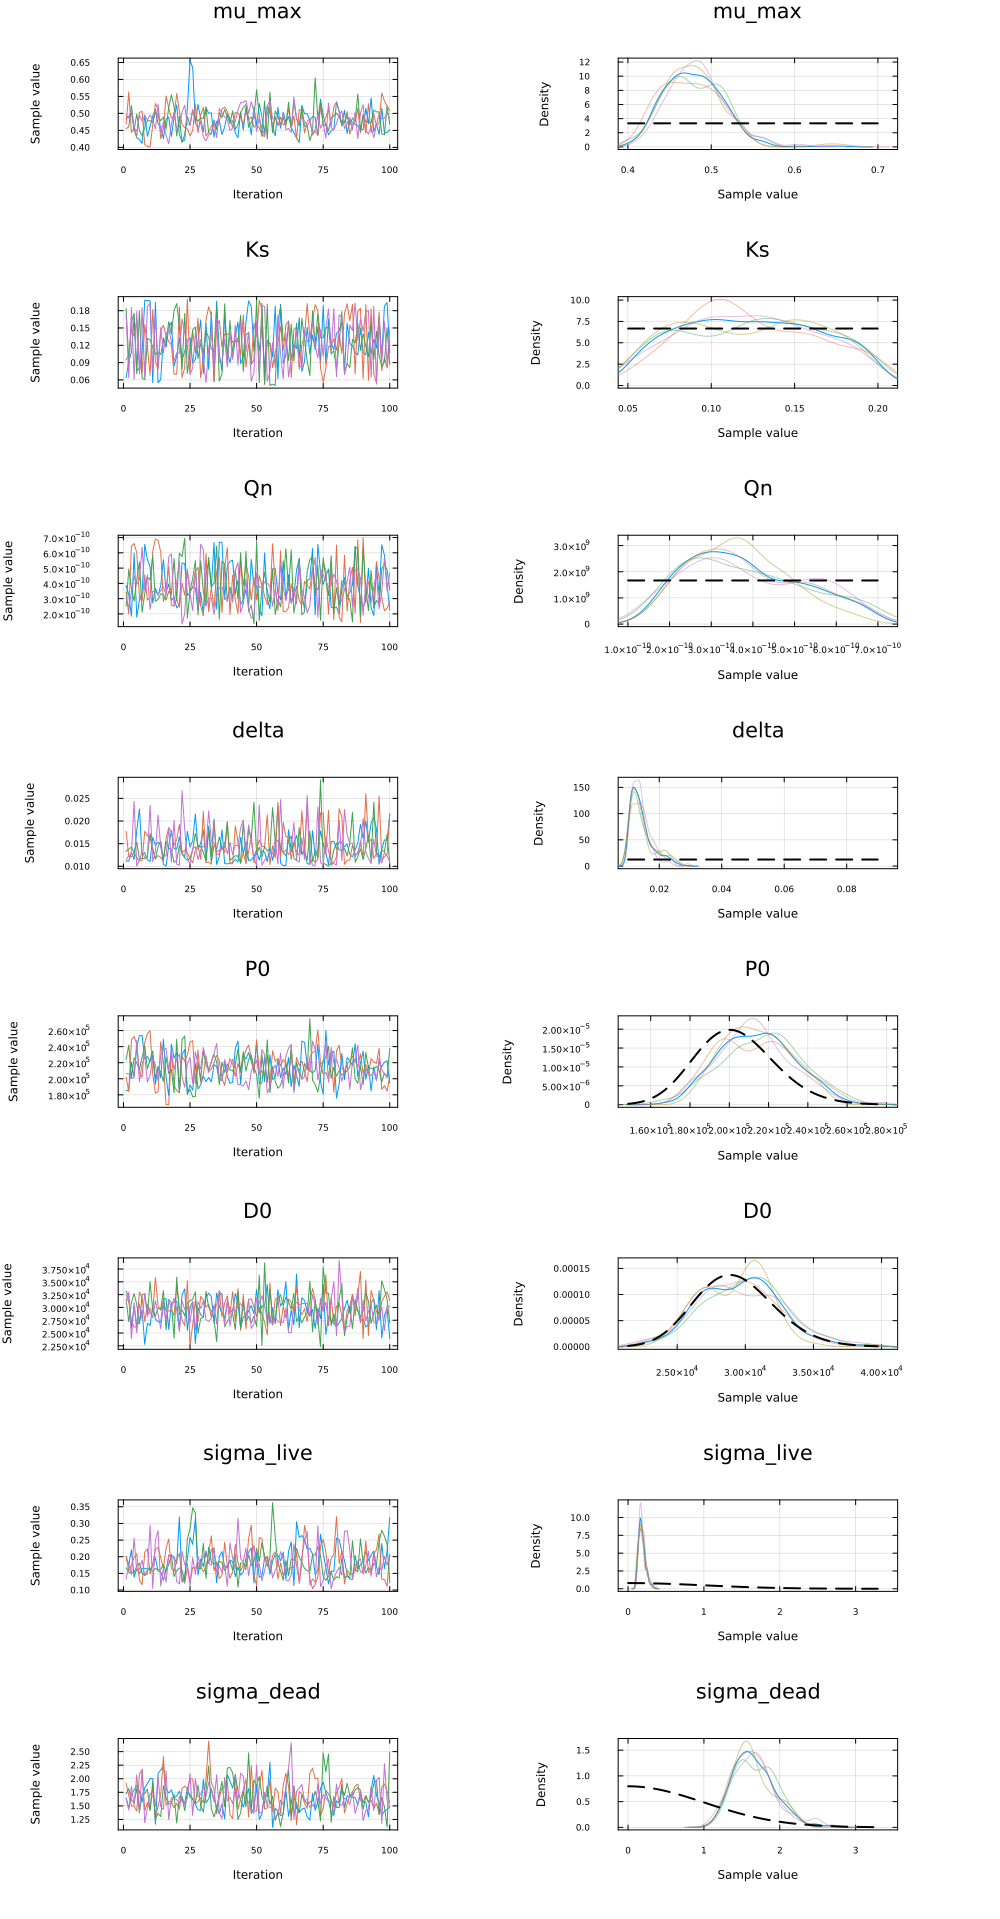

In [6]:
priors = Dict{Symbol,Distribution}(
    :mu_max => Uniform(0.4, 0.7),
    :Ks => Uniform(.05, 0.2),
    :Qn => Uniform(1e-10, 7e-10),
    :delta => Uniform(0.01, 0.09),
    :P0 => LogNormal(12.2175, 0.1),
    :D0 => LogNormal(10.2804, 0.1),
    :sigma_live => truncated(Normal(0, 1), 0, Inf),
    :sigma_dead => truncated(Normal(0, 1), 0, Inf)
)

order = [:mu_max, :Ks, :Qn, :delta, :P0, :D0, :sigma_live, :sigma_dead]

plot_trace_with_priors(chain; priors=priors, var_order=order, per_chain_density=true)  # also per-chain densities